## Synchronization dynamics of Kuramoto oscillators

In [2]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, sys
import time

import torch
import torch.nn as nn
import torch.optim as optim

sys.path.append('../..')
from display import cm, format_axis, format_str, props
from ode import ODE, Kuramoto
from cxs import CXSGrid

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
default_type = torch.float64
torch.set_default_dtype(default_type)

In [4]:
image_dir = '_images/'
model_dir = '_models/'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

### Simulate time series data

In [5]:
method = 'dopri5'
adjoint = False

args = {'N': 80,
        'L': 2.,
        'v': 0,
        'K': 20.,
        's': 1.5
       }
M = 100

kuramoto = Kuramoto(args, method, default_type)
kuramoto.init_state(M)
kuramoto.to(device)

t0 = 10
tf = 50 + t0//2
T = 2*tf + 1
t = torch.linspace(0, tf, T)
T -= t0
print('T:', T)

kuramoto.solve(t, device=device)
kuramoto.trim(t0)

T: 101
Elapsed time: 13.12 s


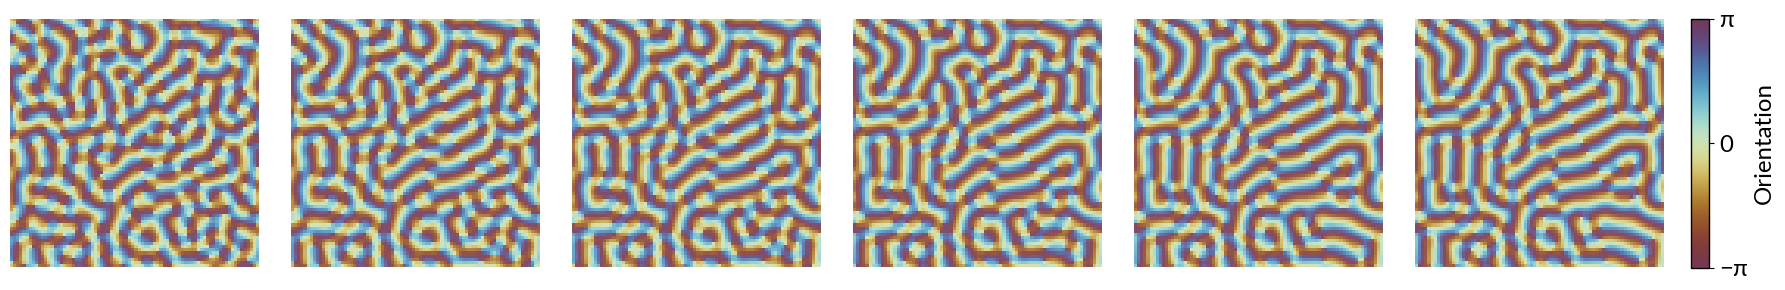

In [6]:
fig = kuramoto.plot_series(kuramoto.y[:,0].reshape(-1,kuramoto.N,kuramoto.N), ntype='mod', clabel='Orientation')

Detector: 84 x 84 	Probe: 13 x 13


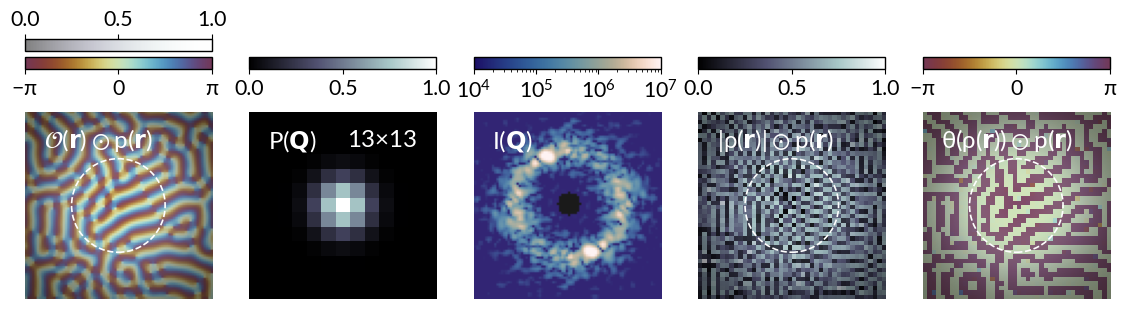

In [7]:
n = 42
dq = 0.5
f_probe = 0.25
f_mask = 0.06
lmax = 0
name = '_'.join([k + format_str(v) for (k,v) in zip(['n', 'dq', 'f', 'lmax'], [n, dq, f_probe, lmax])])

cxs = CXSGrid(kuramoto.N, n, L=kuramoto.L, dq=dq, f_probe=f_probe, f_mask=f_mask, f='phase').to(device)
cxs.shapes()

if lmax:
    vmin = 10**(np.log10(lmax) - 3)
    vmax = lmax
else:
    vmin, vmax = 1e4, 1e7
fig = cxs.plot_example(kuramoto, kuramoto.y[-1,0], ntype='mod', lmax=lmax, vmin=vmin, vmax=vmax)
#fig.savefig(image_dir + 'kuramoto_example_' + name + '.png', bbox_inches='tight', dpi=400, transparent=True)

In [8]:
batch_time = T
batch_size = 1
t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
print(' t:', t_batch.shape)
print('y0:', y0_batch.shape)
print(' y:', y_batch.shape)

cxs(y_batch)
t1 = time.time()
Y_batch = cxs(y_batch)

if lmax:
    Y_batch *= lmax/Y_batch.max()
    Y_batch = torch.poisson(Y_batch)
    
t2 = time.time()
print('Elapsed time: {:.3f} s'.format(t2 - t1))

 t: torch.Size([101])
y0: torch.Size([1, 1, 6400])
 y: torch.Size([101, 1, 1, 6400])
Elapsed time: 0.000 s


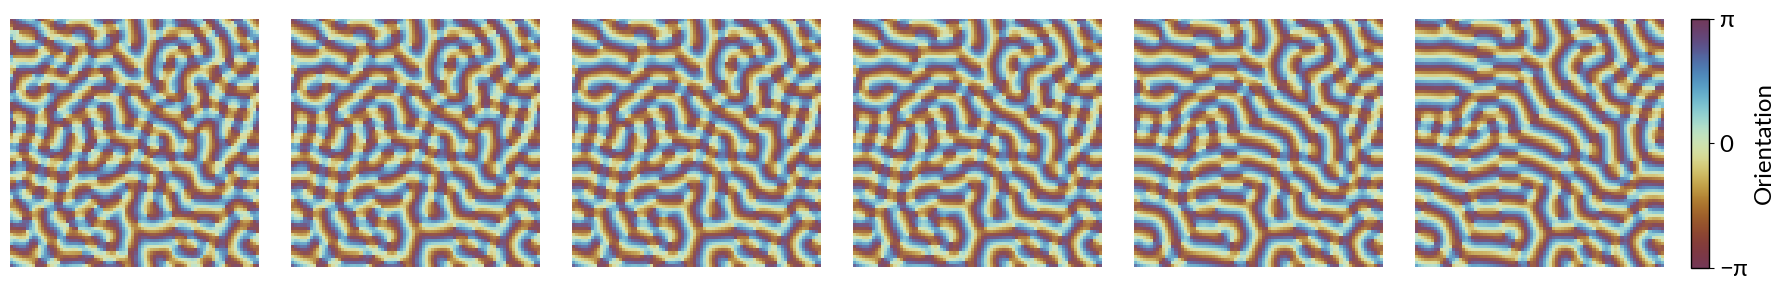

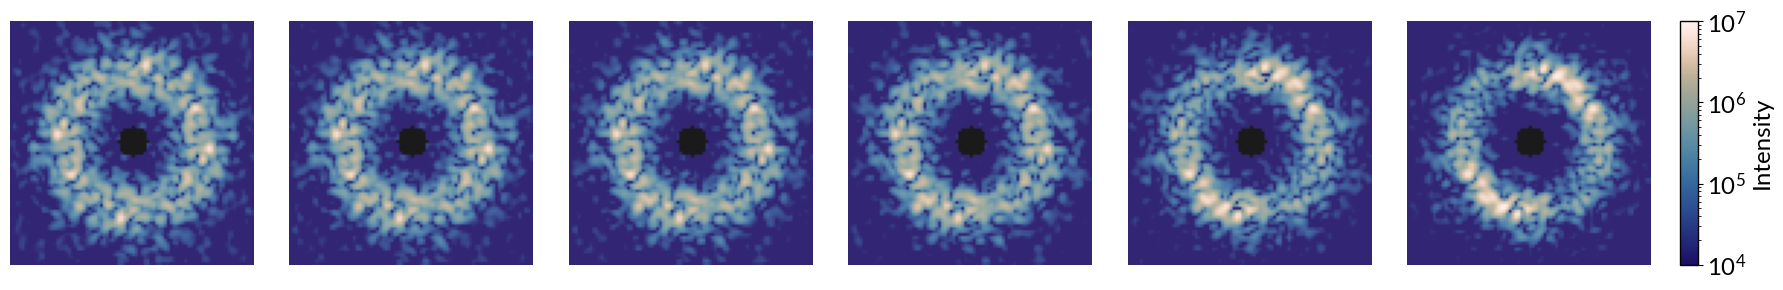

In [9]:
i_eval = kuramoto.get_eval(batch_time, n=6, d=5)

fig = kuramoto.plot_series(y_batch[i_eval,0].reshape(-1,kuramoto.N,kuramoto.N), ntype='mod', clabel='Orientation')
fig = kuramoto.plot_series(Y_batch[i_eval,0].reshape(-1,cxs.n,cxs.n), ntype='log', clabel='Intensity',
                           vmin=vmin, vmax=vmax)

### Define neural ODE model

In [10]:
class NODE(ODE):
    def __init__(self, args, method='dopri5', adjoint=False, default_type=torch.float64):   
        super(NODE, self).__init__(method, adjoint, requires_grad=True, default_type=default_type)
        
        default_args = {'N': 100,
                        'L': 2.,
                        'ks': 11,
                        'n': 64,
                        'dq': 1.,
                        'f_probe': None,
                        'f_mask': None,
                        'w': None,
                        'c': [0.1,1],
                        'lmax': 0
                       }
        
        for k, v in default_args.items():
            setattr(self, k, args[k] if k in args else v)
        
        #self.cxs_data = CXSGrid(self.N, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask,
        #                   f='phase', w=self.w, c=self.c)
        
        self.cxs = CXSGrid(self.N, self.n, L=self.L, dq=self.dq, f_probe=self.f_probe, f_mask=self.f_mask,
                           f='phase', w=self.w, c=self.c)
        
        self.conv = nn.Conv2d(1, 1, self.ks, bias=False, padding='same', padding_mode='circular')
        nn.init.normal_(self.conv.weight, mean=0, std=0.01)
    
    
    def loss(self, y_pred, y_true):
        Y_true = self.cxs(y_true).flatten(start_dim=1)
        Y_pred = self.cxs(y_pred).flatten(start_dim=1)
        
        if self.lmax:
            # Scattering with poisson noise
            C = self.lmax/Y_true[0].max(dim=-1, keepdim=True)[0]
        
            Y_true = C*Y_true
            Y_pred = C*Y_pred
        
            Y_true = torch.poisson(Y_true)
        
            if self.lmax > 1.5e1:
                loss = nn.L1Loss()
            else:
                loss = nn.PoissonNLLLoss(log_input=False, eps=1e-8)
        else:
            # Ideal scattering
            loss = nn.L1Loss()
            
        return loss(Y_pred, Y_true)
        
   
    def forward(self, t, y):
        y = y.view((-1, 1, self.N, self.N))
        cosy = torch.cos(y)
        siny = torch.sin(y)
        conv_cosy = self.conv(cosy)
        conv_siny = self.conv(siny)
        return (cosy*conv_siny - siny*conv_cosy).flatten(start_dim=-2)

In [11]:
method = 'dopri5'
adjoint = False

args = {'N': kuramoto.N,
        'L': kuramoto.L,
        'ks': 11,
        'n': 42,
        'dq': 0.5,
        'f_probe': 0.25,
        'f_mask': 0.06,
        'lmax': 0
       }

node = NODE(args, method, adjoint, default_type).to(device)
node.cxs.shapes()
optimizer = optim.Adam(node.parameters(), lr=5e-3)
print(node)

Detector: 84 x 84 	Probe: 13 x 13
NODE(
  (cxs): CXSGrid(
    (probe): Conv2d(1, 1, kernel_size=(13, 13), stride=(1, 1), padding=same, bias=False)
  )
  (conv): Conv2d(1, 1, kernel_size=(11, 11), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)


In [12]:
model_path = 'T' + str(tf) + '_' + '_'.join(
    k.replace('_','') + format_str(v) for (k,v) in args.items())
image_path = image_dir + model_path + '/'
model_path = model_dir + model_path + '_0.torch'
    
print(image_path)
print(model_path)

_images/T55_N80_L2p0_ks11_n42_dq0p5_fprobe0p25_fmask0p06_lmax0/
_models/T55_N80_L2p0_ks11_n42_dq0p5_fprobe0p25_fmask0p06_lmax0_0.torch


### Train model

In [13]:
class EMA(object):
    def __init__(self, momentum=0.02):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.value = None
        self.avg = 0

    def update(self, value):
        if self.value is None:
            self.avg = value
        else:
            self.avg = self.avg*(1 - self.momentum) + value*self.momentum
        self.value = value

ema = EMA()

In [ ]:
try: saved = torch.load(model_path)
except:
    chkpt = 5
    loss = []
    kernel = []
else:
    chkpt = saved['chkpt']
    loss = saved['loss']
    kernel = saved['kernel']
    node.load_state_dict(saved['state'])
    node.to(device)
    optimizer.load_state_dict(saved['optimizer'])
    ema.update(loss[-1]/ema.momentum)

In [ ]:
node.train()
max_iters = 500
warmup_iters = 0 #2*chkpt
batch_time = 30
batch_size = 20
f_spike = 2

end = time.time()
j = f_spike
for k in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, batch_size)
    y_pred = node.solve(t_batch, y0_batch, device)
    _loss = node.loss(y_pred, y_batch)

    if (k > warmup_iters + 1) and (_loss.item() > (j + 1)*ema.avg):
        print('Restart: Loss:', _loss.item(), 'EMA:', ema.avg)
        saved = torch.load(model_path)
        chkpt = saved['chkpt']
        loss = saved['loss']
        kernel = saved['kernel']
        node.load_state_dict(saved['state'])
        node.to(device)
        optimizer.load_state_dict(saved['optimizer'])
        optimizer.param_groups[0]['lr'] /= 2.
        j += 1
    
    else:
        j = f_spike
        if k > warmup_iters:
            ema.update(_loss.item())

        _loss.backward()
        optimizer.step()

        if k % chkpt == 0:
            with torch.no_grad():
                loss.append(_loss.item())
                kernel.append(node.conv.weight.detach().squeeze().cpu())
                print('Iteration: {:04d} | Total Loss: {:.6e} | Time: {:.6f}'.format(
                    k, _loss.item(), time.time() - end)) 

            end = time.time()
                
        if k % (10*chkpt) == 0:
            torch.save({
                'state': node.state_dict(),
                'optimizer': optimizer.state_dict(),
                'chkpt': chkpt,
                'loss': loss,
                'kernel': kernel,
            }, model_path)

In [54]:
if not os.path.exists(image_path):
    os.makedirs(image_path)
    
torch.save({
    'state': node.state_dict(),
    'optimizer': optimizer.state_dict(),
    'chkpt': chkpt,
    'loss': loss,
    'kernel': kernel,
}, model_path)

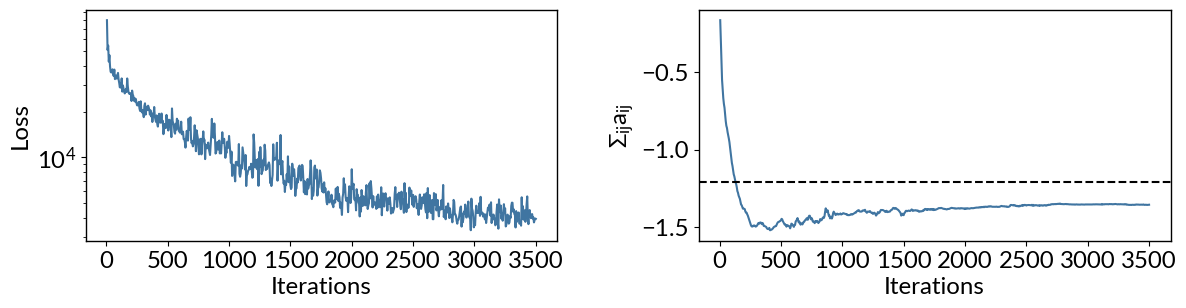

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,3))
fig.subplots_adjust(wspace=0.3)
ax[0].plot(chkpt*np.arange(1,len(loss)+1), loss, color=cm.lapaz(100))
ax[0].set_yscale('log')
#ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
format_axis(ax[0], props, 'Iterations', 'Loss', ybins=4)

kernel_true = kuramoto.K*kuramoto.conv.weight.detach().squeeze().cpu()
ax[1].plot(chkpt*np.arange(1,len(loss)+1), [k.sum() for k in kernel], color=cm.lapaz(100))
ax[1].axhline(kernel_true.sum(), color='black', ls='dashed')
format_axis(ax[1], props, 'Iterations', r'$\Sigma_{ij} a_{ij}$', ybins=4)
#fig.savefig(image_path + 'kuramoto_history.svg', bbox_inches='tight', transparent=True)

### Evaluate model

In [16]:
node.eval()
batch_time = T
i_eval = kuramoto.get_eval(batch_time, n=6, d=5)
t_eval = np.round(kuramoto.t[i_eval].numpy(), decimals=1)

with torch.no_grad():
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, 1)
    y_pred = node.solve(t_batch, y0_batch, device)
    y_diff = y_pred - y_batch
    
    Y_batch = node.cxs(y_batch[i_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[i_eval,0]).reshape(-1,node.cxs.n,node.cxs.n)
    
    if node.lmax:
        Y_batch *= node.lmax/Y_batch.max()
        Y_batch = torch.poisson(Y_batch)
        Y_pred *= node.lmax/Y_pred.max()
    
    Y_diff = Y_pred - Y_batch

Elapsed time: 1.02 s


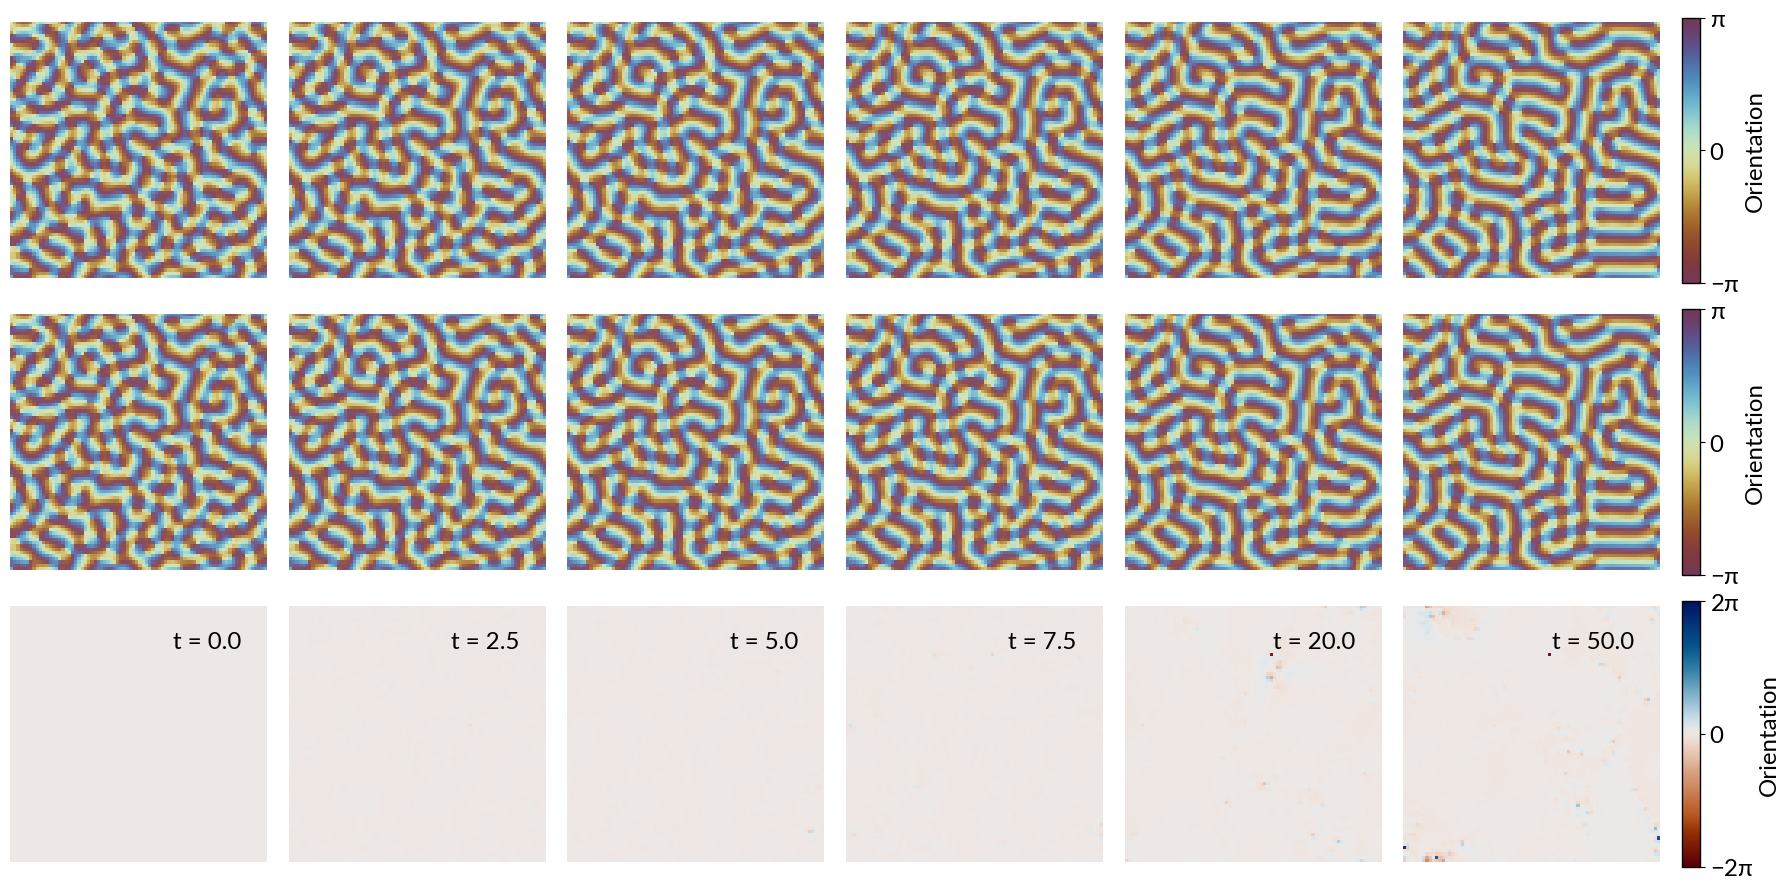

In [17]:
fig = node.plot_series([y_batch[i_eval,0].reshape(-1,node.N,node.N),
                        y_pred[i_eval,0].reshape(-1,node.N,node.N),
                        y_diff[i_eval,0].reshape(-1,node.N,node.N)], ntype=['mod','mod','symmod'],
                       clabel='Orientation')

for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes)

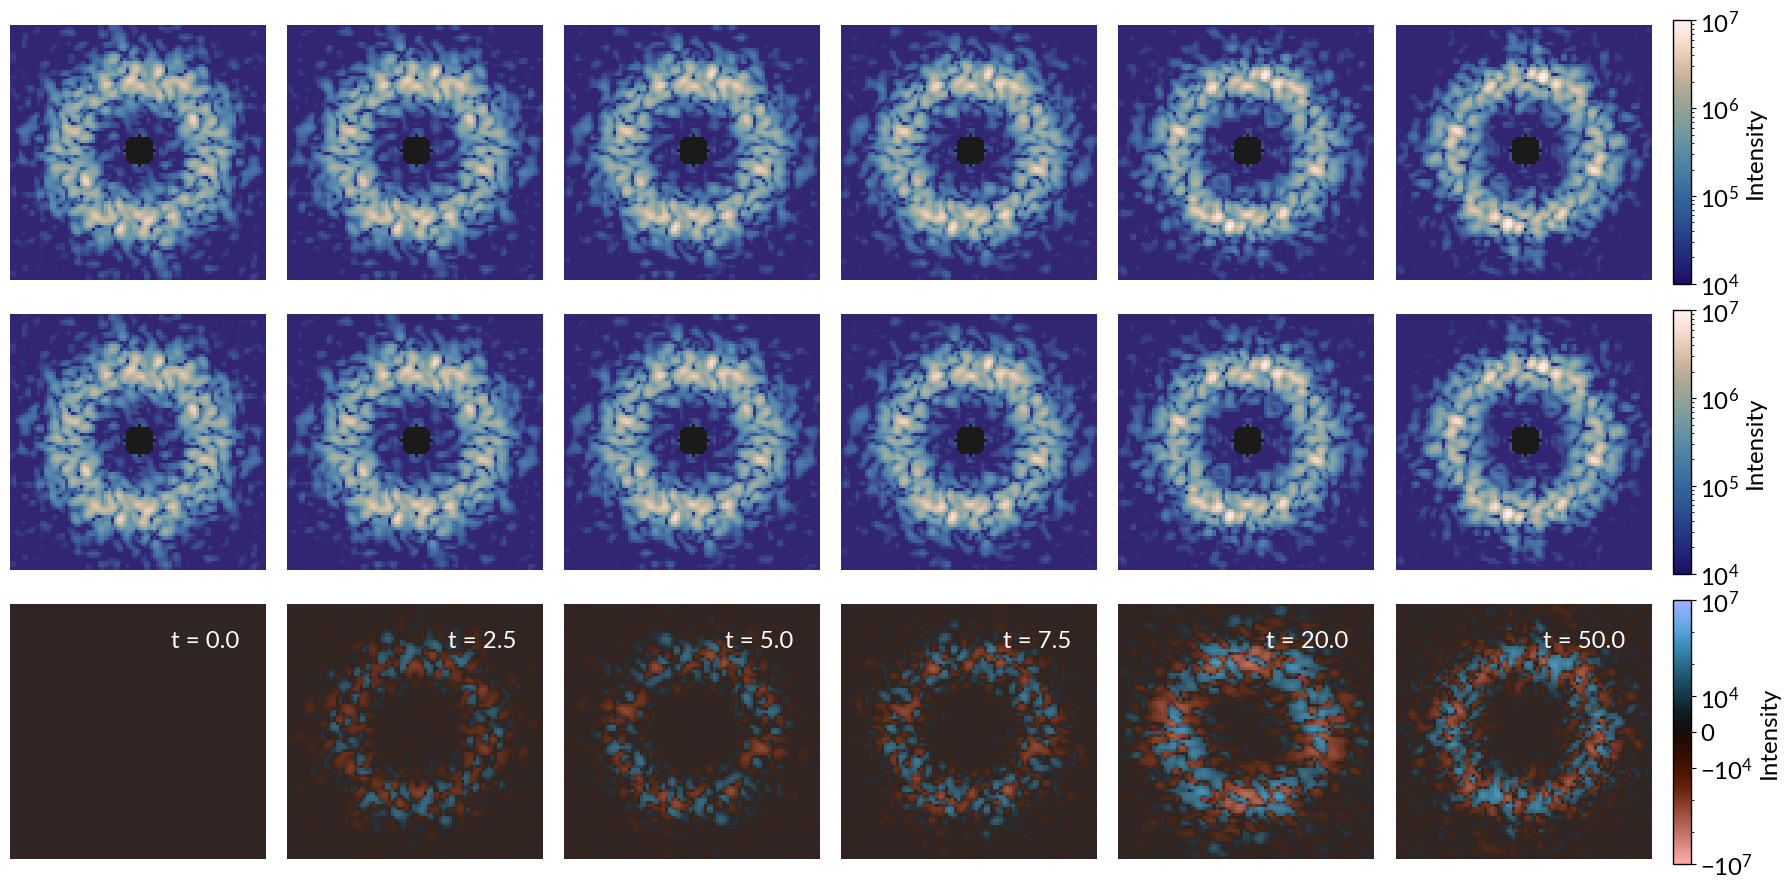

In [18]:
if node.lmax:
    vmin, vmax = 10**(np.log10(node.lmax)-3), node.lmax
else:
    vmin, vmax = 1e4, 1e7
fig = node.plot_series([Y_batch, Y_pred, Y_diff], ntype=['log', 'log', 'symlog'], clabel='Intensity',
                       vmin=vmin, vmax=vmax)

for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)

### Extrapolate model

In [18]:
M = 5

kuramoto.init_state(M)
kuramoto.to(device)

t0 = 10
tf = 250 + t0//2
T = 2*tf + 1
t = torch.linspace(0, tf, T)
T -= t0
print('T:', T)

kuramoto.solve(t, device=device)
kuramoto.trim(t0)

T: 501
Elapsed time: 4.75 s


In [19]:
node.eval()
batch_time = T
i_eval = np.array([0,20,50,100,250,500])
t_eval = np.round(kuramoto.t[i_eval].numpy()).astype(int)

with torch.no_grad():
    t_batch, y0_batch, y_batch = kuramoto.get_batch(batch_time, M)
    y_pred = node.solve(t_batch, y0_batch, device)
    y_diff = y_pred - y_batch
    
    Y_batch = node.cxs(y_batch[:,0]).reshape(-1,node.cxs.n,node.cxs.n)
    Y_pred = node.cxs(y_pred[:,0]).reshape(-1,node.cxs.n,node.cxs.n)
        
    if node.lmax:
        Y_batch *= node.lmax/Y_batch.max()
        Y_batch = torch.poisson(Y_batch)
        Y_pred *= node.lmax/Y_pred.max()
    
    Y_diff = Y_pred - Y_batch

Elapsed time: 3.91 s


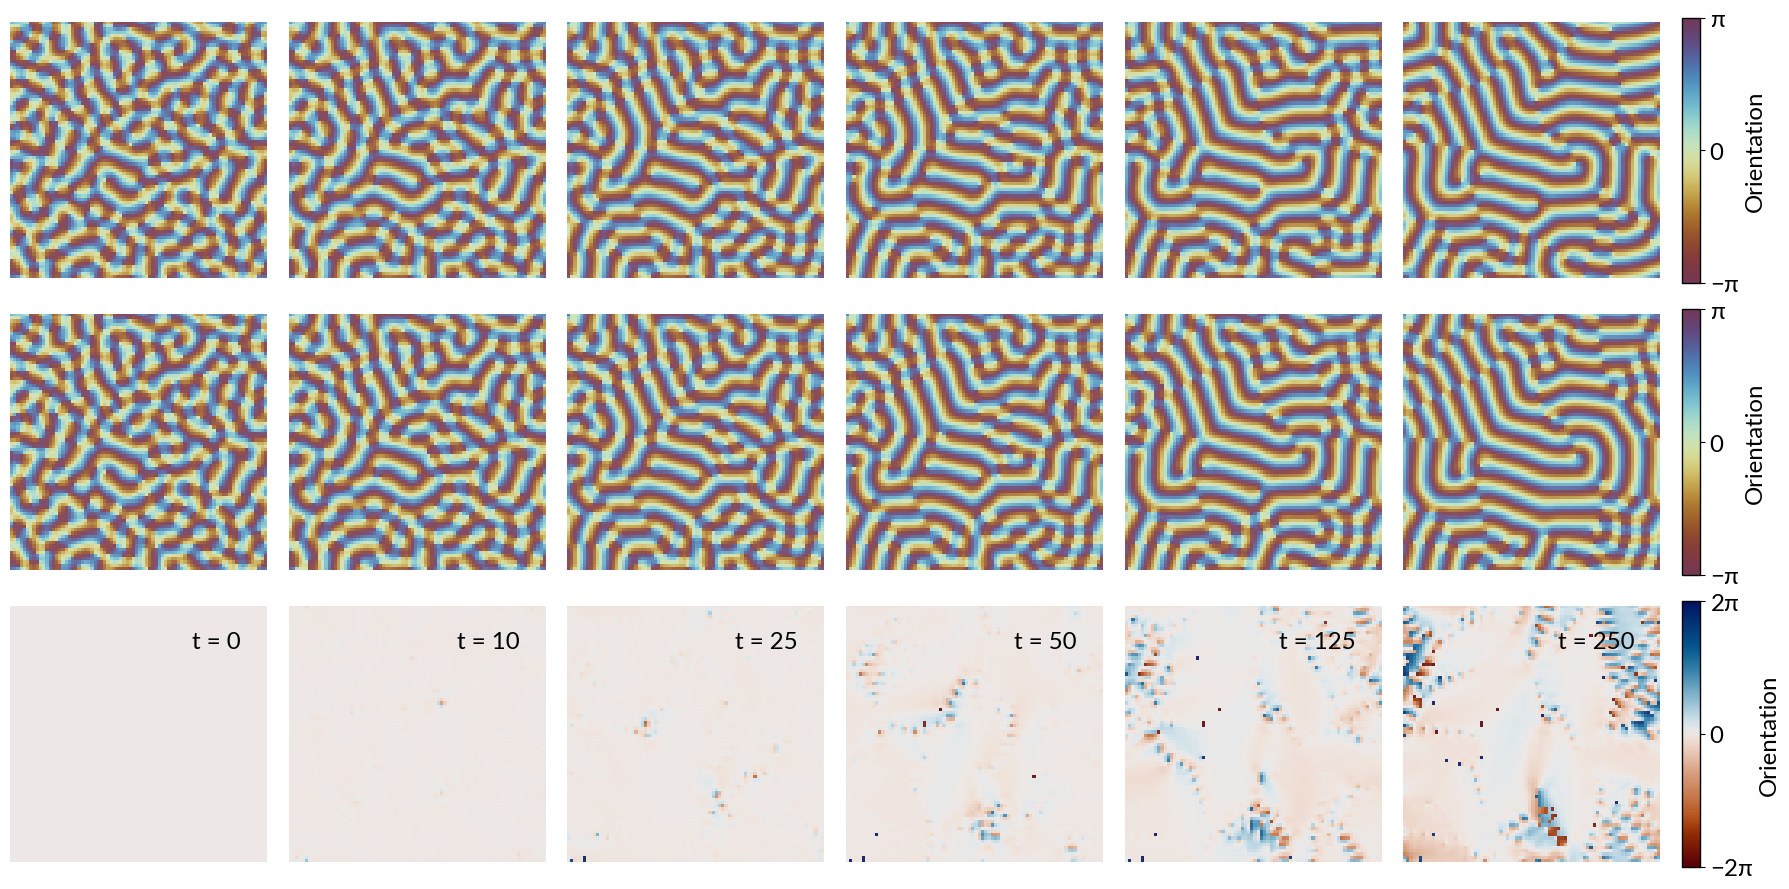

In [20]:
fig = node.plot_series([y_batch[i_eval,0].reshape(-1,node.N,node.N),
                        y_pred[i_eval,0].reshape(-1,node.N,node.N),
                        y_diff[i_eval,0].reshape(-1,node.N,node.N)], ntype=['mod','mod','symmod'],
                       clabel='Orientation')

for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), ha='right', va='top', fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_path + 'kuramoto_real.png', dpi=400, bbox_inches='tight', transparent=True)

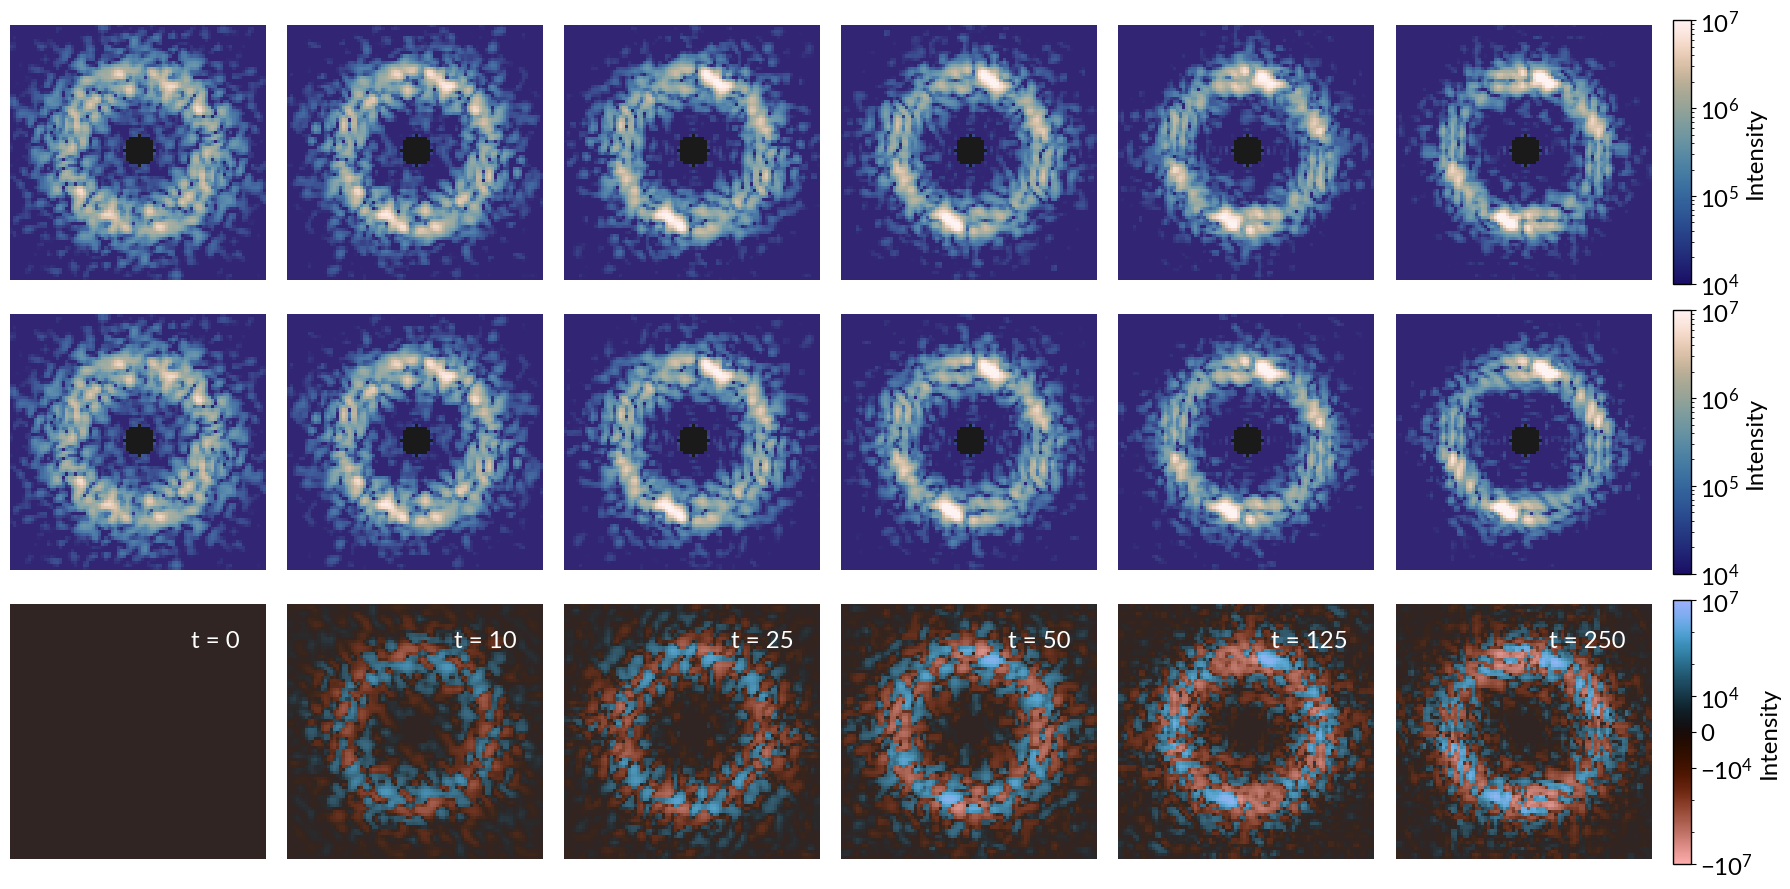

In [21]:
if node.lmax:
    vmin, vmax = 10**(np.log10(node.lmax)-3), node.lmax
else:
    vmin, vmax = 1e4, 1e7
fig = node.plot_series([Y_batch[i_eval], Y_pred[i_eval], Y_diff[i_eval]], ntype=['log', 'log', 'symlog'],
                       vmin=vmin, vmax=vmax, clabel='Intensity')
for i, ax in enumerate(fig._localaxes[-7:-1]):
    ax.text(0.9, 0.9, 't = ' + str(t_eval[i]), color='white', ha='right', va='top',
            fontproperties=props, transform=ax.transAxes)
#fig.savefig(image_path + 'kuramoto_fourier.png', dpi=400, bbox_inches='tight', transparent=True)